## Project purpose
The goal of this project was to build several several different types of recommendation systems in order to better understand how they work through practice. In my Marketing Analytics course, we covered some of the advantages of recommendation systems. However, we never put these ideas into practice. In this application with restaurants, customers tend to seek out new culinary experiences that fit their requirements. With a recommendation system, business value can be generated via taking a cut of profits from restaurants generated by generating new customers with a higher customer retention and order value assuming that the recommendations are high-quality. This is a win-win for businesses and customers as customers receive an enhanced dining experience from a recommendation tailored towards them. In this way, value is generated for everyone: the company with the recommendation system, the restaurants, and the customers.

Outside of restaurants, recommendation engines are extremely useful for driving web traffic and providing relevant content such as advertisements to users. A notable example is Google, which is valued at over \$1 trillion and is essentially a recommendation system that makes its money from ads.

## About the Data
The data was taken from a small Kaggle competition named "Restaurant Recommendation Challenge." The original competition was to build a recommendation engine to which restaurants customers are most likely to order given "customer location", "restaurant information", and "customer order history". However, I was more interested in learning about building recommendation engines, so I did not follow these rules. Instead, I have taken 2 datasets, orders.csv and vendors.csv, and ignored the other provided training and testing datasets. 

Orders.csv is 135,303 rows and 26 columns. Some of these columns are:
1. Order amount
2. Count of items in order
3. Customer ID
4. Vendor ID
5. Promo code
6. Is favorite
7. Vendor rating
8. Delivery distance
9. Location type
10. Delivery date

Vendors.csv is a much smaller dataset with 100 rows and 60 columns. Among these columns are:
1. Vendor ID
2. Location
3. Opening hours
4. Day of week
5. Types of food served
6. Vendor category

## Content
1. Exploratory Data Analysis
2. Matrix Factorization Collaborative Filtering
3. Item-Based Collaborative Filtering
4. Market Basket Analysis
5. Benchmarking
6. Summary

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sys
from scipy import stats # statistical library
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import copy

matplotlib.style.use('ggplot')

from scipy.sparse.linalg import svds #for matrix factorization
from mlxtend.frequent_patterns import apriori, association_rules 

Populating the interactive namespace from numpy and matplotlib


In [22]:
orders = pd.read_csv('orders.csv', low_memory=False)
orders.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [23]:
vendors = pd.read_csv('vendors.csv')
vendors.head()

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


## 1. Exploratory Data Analysis

In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   akeed_order_id                  135233 non-null  float64
 1   customer_id                     135303 non-null  object 
 2   item_count                      128378 non-null  float64
 3   grand_total                     135303 non-null  float64
 4   payment_mode                    135303 non-null  int64  
 5   promo_code                      4305 non-null    object 
 6   vendor_discount_amount          135303 non-null  float64
 7   promo_code_discount_percentage  65880 non-null   float64
 8   is_favorite                     100108 non-null  object 
 9   is_rated                        135303 non-null  object 
 10  vendor_rating                   45220 non-null   float64
 11  driver_rating                   135303 non-null  float64
 12  deliverydistance

There seems to be a ton of missing values in important columns. Of the 135,233 rows, only 45,220 have vendor ratings. I then looked into the non-null ratings.

In [25]:
orders[orders['vendor_rating'].notnull()]['vendor_rating'].value_counts()

0.0    25175
5.0    14212
4.0     2748
3.0     1426
1.0     1029
2.0      630
Name: vendor_rating, dtype: int64

A lot of values are 0, so I will omit these ratings as well.

In [26]:
orders = orders[orders['vendor_rating'].notnull()]
orders[orders['vendor_rating']!=0]['vendor_rating'].value_counts()

5.0    14212
4.0     2748
3.0     1426
1.0     1029
2.0      630
Name: vendor_rating, dtype: int64

<AxesSubplot:title={'center':'Distribution of Ratings'}>

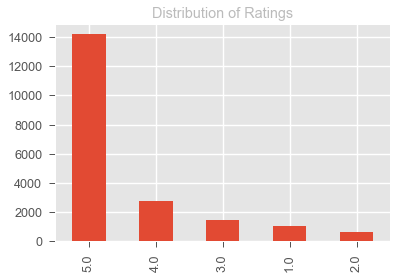

In [27]:
orders[orders['vendor_rating']!=0]['vendor_rating'].value_counts().plot(kind='bar',
                                            title='Distribution of Ratings')

In [28]:
#use data only with valid vendor ratings
orders = orders[orders['vendor_rating']!=0]
orders.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
101,163425.0,OH64IO0,2.0,10.8,1,NaN,0.0,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,2019-08-01 05:30:00,310,2019-08-01 19:06:34,0,NaN,OH64IO0 X 0 X 310
159,163543.0,FCPLE31,3.0,28.0,1,NaN,0.0,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,2019-08-01 05:30:00,157,2019-08-01 20:53:27,0,Home,FCPLE31 X 0 X 157
175,163573.0,WB681BO,2.0,11.7,2,NaN,0.0,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,2019-08-01 05:30:00,271,2019-08-01 21:25:42,0,Home,WB681BO X 0 X 271
272,163764.0,FS229TW,2.0,9.5,1,NaN,0.0,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,2019-08-01 05:30:00,157,2019-08-02 03:12:32,0,Other,FS229TW X 0 X 157
453,164175.0,3P9113W,1.0,9.8,1,NaN,0.0,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,2019-08-02 05:30:00,85,2019-08-03 00:39:57,0,Other,3P9113W X 0 X 85


In [29]:
#number of unique customers
orders['customer_id'].nunique()

7726

In [30]:
#Amount of orders from top 10 customers
orders['customer_id'].value_counts()[:10]

XW90EAP    78
2JJAO46    68
HJFTTGW    54
DGRUO7S    54
VDEJEMP    47
U31BNUR    46
HSKCXYG    43
VSQM72V    43
TL7Z2DM    42
WM6KURU    37
Name: customer_id, dtype: int64

In [31]:
#grand totals of vendors
vendors_sum = pd.pivot_table(orders,
                         index='vendor_id',
                         values='grand_total',
                         aggfunc=np.sum)

vendors_sum.sort_values(by='grand_total',ascending=False)

,grand_total
vendor_id,
113,14692.2
79,13923.6
84,13756.8
105,9832.6
386,8920.4
...,...
66,315.0
161,286.7
265,236.6


<AxesSubplot:title={'center':'Top 10 Most Rated Restaurants'}, xlabel='vendor_id'>

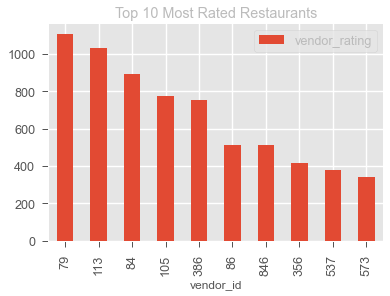

In [32]:
vendors_pt = pd.pivot_table(orders,
                         index='vendor_id',
                         values='vendor_rating',
                         aggfunc='count')
vendors_pt.sort_values(by='vendor_rating', ascending=False)[:10]\
    .plot(kind='bar',title='Top 10 Most Rated Restaurants')

(0.0, 100.0)

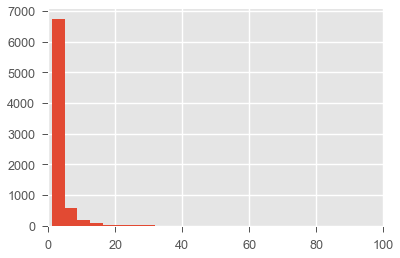

In [33]:
#Ratings per User
orders['customer_id'].value_counts().hist(bins=20).set_xlim(0,100)

In [34]:
vendors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    100 non-null    int64  
 1   authentication_id     100 non-null    float64
 2   latitude              100 non-null    float64
 3   longitude             100 non-null    float64
 4   vendor_category_en    100 non-null    object 
 5   vendor_category_id    100 non-null    float64
 6   delivery_charge       100 non-null    float64
 7   serving_distance      100 non-null    float64
 8   is_open               100 non-null    float64
 9   OpeningTime           91 non-null     object 
 10  OpeningTime2          91 non-null     object 
 11  prepration_time       100 non-null    int64  
 12  commission            85 non-null     float64
 13  is_akeed_delivering   100 non-null    object 
 14  discount_percentage   100 non-null    float64
 15  status                10

In [35]:
#combine datasets
com = vendors.merge(orders,left_on='id',right_on='vendor_id')
com.head()

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at_y,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,NaN,NaN,NaN,NaN,2019-08-05 05:30:00,4,2019-08-05 19:32:22,0,Home,FHMEG6N X 0 X 4
1,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,NaN,NaN,NaN,NaN,2019-08-08 05:30:00,4,2019-08-08 18:09:37,0,Work,FWNWSYH X 0 X 4
2,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,NaN,NaN,NaN,NaN,2019-08-19 05:30:00,4,2019-08-19 18:10:02,0,Home,FHMEG6N X 0 X 4
3,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,NaN,NaN,NaN,NaN,2019-08-26 05:30:00,4,2019-08-26 18:57:51,1,Home,VXJJYH2 X 1 X 4
4,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,NaN,NaN,NaN,NaN,2019-09-04 05:30:00,4,2019-09-04 19:11:39,0,Home,GO7LLZH X 0 X 4


<AxesSubplot:xlabel='grand_total', ylabel='vendor_rating_x'>

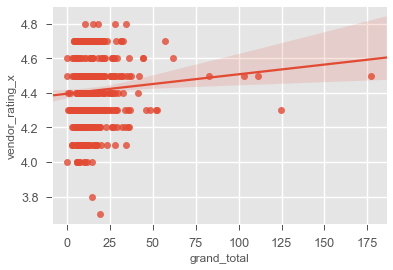

In [37]:
sns.regplot(x='grand_total',y='vendor_rating_x',data=com.sample(500))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Desserts'),
  Text(1, 0, 'Sandwiches'),
  Text(2, 0, 'Burgers'),
  Text(3, 0, 'Salads'),
  Text(4, 0, 'American'),
  Text(5, 0, 'Breakfast'),
  Text(6, 0, 'Free Delivery'),
  Text(7, 0, 'Fries'),
  Text(8, 0, 'Fresh Juices'),
  Text(9, 0, 'Pasta')])

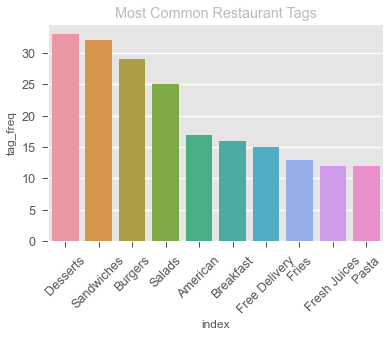

In [38]:
vendor_tags = {}
for lst in com['vendor_tag_name'].unique():
    if isinstance(lst, str):
        tags = lst.split(',')
        for tag in tags:
            if tag not in vendor_tags:
                vendor_tags[tag] = 1
            else:
                vendor_tags[tag] += 1
types = pd.DataFrame.from_dict(vendor_tags,orient='index',columns=['tag_freq'])
types.reset_index(inplace=True)
types = types.sort_values(by='tag_freq',ascending=False)[:10]
sns.barplot(x='index',y='tag_freq',data=types).set_title('Most Common Restaurant Tags')
plt.xticks(rotation=45)

# Modeling
---
There are 2 ways to make recommendations: model-driven approaches and heuristics approaches. Model-driven apporaches are creating models using some form of attributes or behavior of the restaurant or customers. It is important to note that this is highly dependent on the analyst's ability to determine what to model. I decided not to pursue this approach process due to limitations.

Heuristics approaches uses a simple rule of thumb approach to making recommendations. From "stated" preference data, such as customer ratings, we can use the collaborative filtering process. From "revealed" preference data, such as the customer's purchase history, we can attempt a market basket analysis.


## 2. Matrix Factorization Collaborative Filtering
In collaborative filtering, we are trying to answer the question: for each of the customers who left at least one rating, can we recommend other restaurants that they have not yet rated?

In terms of data preparation, the biggest problem was that data was very sparse. Most customers did not rate any restaurants, and more than half of the ratings were recorded as zero, which was not usable. Thus, after removing all the unusable data, I had about 20k out of 135k orders. There were 7,726 customers who rated at least once, which is about 28% of all the customers.

The matrix factorization method I used was SVD (Singular Value Decomposition). 

In [39]:
# Get unique vendor ratings
orders_by_cust1 = orders[['customer_id','item_count','grand_total','vendor_rating','driver_rating','deliverydistance','vendor_id']]
orders_by_cust1.head()

,customer_id,item_count,grand_total,vendor_rating,driver_rating,deliverydistance,vendor_id
101,OH64IO0,2.0,10.8,5.0,5.0,0.0,310
159,FCPLE31,3.0,28.0,5.0,5.0,0.0,157
175,WB681BO,2.0,11.7,4.0,3.0,0.0,271
272,FS229TW,2.0,9.5,4.0,0.0,0.0,157
453,3P9113W,1.0,9.8,5.0,5.0,0.0,85


In [40]:
#remove 0 ratings
orders_by_cust = orders_by_cust1[orders_by_cust1['vendor_rating'] != 0]

df_by_vendors = orders_by_cust.groupby(['vendor_id','customer_id']).mean().reset_index()
df_by_customers = orders_by_cust.groupby(['customer_id','vendor_id']).mean().reset_index()
print(df_by_vendors)
print(df_by_customers)

       vendor_id customer_id  item_count  grand_total  vendor_rating  \
0              4     00OT8JX         3.5    19.566667            5.0   
1              4     045FUZC         3.0    16.600000            4.5   
2              4     0GQAWGX         3.0     0.300000            4.0   
3              4     0HITBVB         2.0     6.000000            1.0   
4              4     0J3JAWH         4.0    13.000000            4.0   
...          ...         ...         ...          ...            ...   
13487        907     Y9CGJXL         2.0     1.600000            5.0   
13488        907     YR1DNQ2         4.0     6.800000            5.0   
13489        907     Z7FF89G         3.0     4.600000            2.0   
13490        907     ZFSSWBV         3.0     5.200000            5.0   
13491        907     ZOZJYNW         1.0     0.500000            1.0   

       driver_rating  deliverydistance  
0                5.0          6.656667  
1                4.5          2.420000  
2           

In [41]:
df_by_customers_rating = copy.deepcopy(df_by_customers[['customer_id', 'vendor_id', 'vendor_rating']])

# map the customer ids and vendor ids to vendor rating
# NOTE: The new vendor_id_int is different number from the original vendor_id
df_by_customers_rating["customer_id_int"] = df_by_customers_rating['customer_id'].rank(method ='dense').astype(int)
df_by_customers_rating["vendor_id_int"]   = df_by_customers_rating['vendor_id'].rank(method ='dense').astype(int) 

# Need to merge vendor food type info while vendor_id_int is in the same dataframe
df_by_cust_rating_with_vendor_type = (df_by_customers_rating.merge(vendors, how = 'left', left_on = 'vendor_id', right_on = 'id').sort_values(['customer_id_int'], ascending=False) )

#this is the df for filtering
df_by_cust_rating_newid = df_by_customers_rating[['customer_id_int', 'vendor_id_int','vendor_rating']]
print(df_by_cust_rating_newid.head())

R_df = df_by_cust_rating_newid.pivot(index = 'customer_id_int', columns ='vendor_id_int', values = 'vendor_rating').fillna(0)
R_df.head()

   customer_id_int  vendor_id_int  vendor_rating
0                1             69            5.0
1                2              1            5.0
2                2             12            5.0
3                2             24            5.0
4                2             36            5.0


vendor_id_int,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
customer_id_int,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
#get normalized predictions for each customer vendor combination
R = R_df.to_numpy()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

#50 seemed optimal after several experiments
U, sigma, Vt = svds(R_demeaned, k = 50)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)

preds_df.head()

vendor_id_int,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0.012819,0.038799,-0.026204,0.022984,-0.004424,0.005693,0.064137,-0.006207,-0.042939,0.065478,...,-0.006656,-0.035703,0.016041,0.065568,-0.005374,-0.007976,0.006558,-0.002519,-0.006368,-0.085490
1,4.899561,0.661909,0.483003,1.280933,-0.019898,-0.271581,0.850224,-0.258311,0.180038,0.252474,...,0.076503,3.989999,0.461602,-1.145496,0.093760,-0.007099,0.201754,-0.150468,5.125211,0.332882
2,0.004642,-0.012281,0.025886,0.034094,0.004649,0.000265,-0.020598,0.002341,0.008966,-0.015406,...,0.001981,-0.009087,-0.003607,-0.036538,-0.001957,0.004210,0.004978,0.005596,0.004563,0.020645
3,-0.140588,0.177283,0.066214,0.252978,-0.013158,4.899357,0.095169,-0.002582,-0.039602,-0.042523,...,0.003318,0.192196,0.091285,-0.011703,-0.002175,0.003249,0.020326,0.013127,-0.008414,-0.008617
4,0.083534,0.173825,0.475965,-0.078022,-0.025509,-0.011703,-0.043810,-0.084218,0.153664,0.106907,...,0.089221,-0.431894,0.051428,0.706687,0.125887,-0.032379,-0.401004,-0.138695,-0.040884,0.142680


In [43]:
#make recommendations
def recommend_restaurants(predictions_df, userID, res_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the book information.
    user_data = original_ratings_df[original_ratings_df.customer_id_int == (userID)]
    user_full = (user_data.merge(res_df, how = 'left', left_on = 'vendor_id_int', right_on = 'vendor_id_int').
                     sort_values(['vendor_rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} restaurants. The first 5 are:'.format(userID, user_full.shape[0]))
    print (user_full['vendor_tag_name'].head(5))
    print ('Recommending the highest {0} predicted ratings restaurants not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating book that the user hasn't seen yet.
    recommendations = (res_df[~res_df['vendor_id_int'].isin(user_full['vendor_id_int'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'vendor_id_int',
               right_on = 'vendor_id_int').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

#    return user_full, recommendations
    return recommendations

In [44]:
#get vendor tag each vendor id to substitute for missing restaurant name
vendors_id_type = df_by_cust_rating_with_vendor_type[['vendor_id_int','vendor_tag_name']].drop_duplicates()
vendors_id_type

,vendor_id_int,vendor_tag_name
13491,81,"American,Burgers,Desserts,Free Delivery,Fries,..."
13490,80,"Burgers,Free Delivery,Milkshakes,Mojitos"
13489,55,"Breakfast,Free Delivery,Fresh Juices,Fries,Kar..."
13488,21,"Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ..."
13487,43,"Fresh Juices,Milkshakes,Mojitos ,Sandwiches,Sh..."
...,...,...
12806,71,"Coffee,Fresh Juices,Hot Chocolate,Sandwiches,S..."
12699,16,"Arabic,Breakfast,Desserts,Mandazi,Omani,Salads..."
12364,61,"Desserts,Free Delivery,Fresh Juices,Healthy Fo..."
12127,56,NaN


In [45]:
recommend_restaurants(preds_df, 31, vendors_id_type, df_by_cust_rating_newid, 5)

User 31 has already rated 3 restaurants. The first 5 are:
0    Breakfast,Desserts,Grills,Milkshakes,Salads,Sa...
1                     Burgers,Fries,Kids meal,Shawarma
2    Fresh Juices,Milkshakes,Mojitos ,Sandwiches,Sh...
Name: vendor_tag_name, dtype: object
Recommending the highest 5 predicted ratings restaurants not already rated.


,vendor_id_int,vendor_tag_name
33,85,"Burgers,Desserts,Family Meal,Salads"
82,39,"Breakfast,Desserts,Grills,Milkshakes,Salads,Sa..."
24,46,"Burgers,Fries,Grills,Mishkak,Mojitos ,Sandwich..."
72,77,"Omani,Arabic,Shuwa,Pasta,Rice,Soups,Lebanese"
43,88,"Fresh Juices,Sandwiches,Shawarma"


From this predicted ratings table, we could show for each customer, our top recommended restaurants. Because the data did not have the restaurant names, I substituted the type of food they serve. The biggest limitation of this result is that over 70% of the customers did not give any ratings.

In [69]:
#repeat recommendations for each customer
k = pd.DataFrame()
for index in range(7726):
  j = recommend_restaurants(preds_df, index+1, vendors_id_type, df_by_cust_rating_newid, 2)
  k = k.append(j)

User 1 has already rated 1 restaurants. The first 5 are:
0    Combos,Fries,Mojitos ,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 2 has already rated 10 restaurants. The first 5 are:
0    Arabic,Breakfast,Burgers,Desserts,Free Deliver...
1    Asian,Desserts,Healthy Food,Japanese,Salads,Sushi
2        American,Burgers,Free Delivery,Hot Dogs,Pasta
3                          American,Burgers,Sandwiches
4               Italian,Pasta,Pizzas,Salads,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 3 has already rated 1 restaurants. The first 5 are:
0    Burgers,Fries,Kids meal,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 4 has already rated 1 restaurants. The first 5 are:
0    Desserts,Mexican
Name: vendor_tag_name, dtype: object
Recommending the

User 40 has already rated 3 restaurants. The first 5 are:
0                          American,Burgers,Sandwiches
2    Coffee,Fresh Juices,Hot Chocolate,Sandwiches,S...
1                                       Coffee,Organic
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 41 has already rated 2 restaurants. The first 5 are:
1    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
0              Asian,Desserts,Rice,Salads,Soups,Thai
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 42 has already rated 1 restaurants. The first 5 are:
0    Fatayers,Mojitos ,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 43 has already rated 1 restaurants. The first 5 are:
0    Asian,Desserts,Rice,Salads,Soups,Thai
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings

User 78 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 79 has already rated 1 restaurants. The first 5 are:
0    Desserts,Mexican
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 80 has already rated 7 restaurants. The first 5 are:
0                                            Burgers
1    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
2               Arabic,Desserts,Free Delivery,Indian
3             American,Kids meal,Pasta,Pizzas,Salads
4                Biryani,Desserts,Indian,Kebabs,Rice
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 81 has already rated 1 restaurants. The first 5 are:
0    Fresh Juices,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending t

User 114 has already rated 2 restaurants. The first 5 are:
0    Arabic,Desserts,Free Delivery,Indian
1        Fresh Juices,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 115 has already rated 2 restaurants. The first 5 are:
1    American,Burgers,Desserts,Free Delivery,Fries,...
0    Arabic,Breakfast,Burgers,Desserts,Free Deliver...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 116 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 117 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Family Meal,Salads
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 118 has already rat

User 155 has already rated 1 restaurants. The first 5 are:
0    Asian,Dimsum,Grills,Japanese,Rice,Soups
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 156 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 157 has already rated 1 restaurants. The first 5 are:
0    Breakfast,Desserts,Grills,Milkshakes,Salads,Sa...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 158 has already rated 1 restaurants. The first 5 are:
0    Breakfast,Desserts,Grills,Milkshakes,Salads,Sa...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 159 has already rated 1 restaurants. The first 5 are:
0    Fresh Juices,Sandwiches,Shawarma
Name: v

User 188 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 189 has already rated 1 restaurants. The first 5 are:
0    Biryani,Desserts,Indian,Kebabs,Rice
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 190 has already rated 1 restaurants. The first 5 are:
0    Breakfast,Burgers,Grills,Pizza,Sandwiches,Shaw...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 191 has already rated 2 restaurants. The first 5 are:
0    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
1      American,Burgers,Free Delivery,Hot Dogs,Pasta
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 192 has already rated 2 restaurants. The first 5 a

User 220 has already rated 8 restaurants. The first 5 are:
6                                              Churros
3    Breakfast,Burgers,Grills,Pizza,Sandwiches,Shaw...
2             American,Burgers,Desserts,Mojitos ,Pasta
7                            Arabic,Kushari,Sandwiches
4    Arabic,Biryani,Chinese,Grills,Indian,Rice,Sala...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 221 has already rated 2 restaurants. The first 5 are:
0    Omani,Arabic,Shuwa,Pasta,Rice,Soups,Lebanese
1       Burgers,Free Delivery,Milkshakes,Mojitos 
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 222 has already rated 1 restaurants. The first 5 are:
0    Frozen yoghurt,Smoothies
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 223 has already rated 1 restaurants. The first 5 are:
0    Burgers
Name: v

User 254 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 255 has already rated 2 restaurants. The first 5 are:
0    Asian,Dimsum,Grills,Japanese,Rice,Soups
1           Fresh Juices,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 256 has already rated 2 restaurants. The first 5 are:
0    American,Burgers,Free Delivery,Hot Dogs,Pasta
1                                          Churros
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 257 has already rated 1 restaurants. The first 5 are:
0    American,Burgers,Desserts,Mojitos ,Pasta
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 258 has alread

0    American,Burgers,Fries,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 296 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Family Meal,Salads
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 297 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 298 has already rated 1 restaurants. The first 5 are:
0    American,Burgers,Desserts,Free Delivery,Fries,...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 299 has already rated 1 restaurants. The first 5 are:
0    American,Kids meal,Pasta,Pizzas,Salads
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted rati

User 332 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 333 has already rated 1 restaurants. The first 5 are:
0    Fresh Juices,Lebanese,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 334 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 335 has already rated 1 restaurants. The first 5 are:
0    American,Burgers,Desserts,Free Delivery,Fries,...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 336 has already rated 2 restaurants. The first 5 are:
0    American,Burgers,Fries,Sandwiches
1 

User 372 has already rated 1 restaurants. The first 5 are:
0    Desserts,Mexican
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 373 has already rated 6 restaurants. The first 5 are:
0                 Arabic,Desserts,Free Delivery,Indian
1           Desserts,Free Delivery,Healthy Food,Sweets
2                          American,Burgers,Sandwiches
5    American,Breakfast,Burgers,Cafe,Desserts,Free ...
4            Fresh Juices,Lebanese,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 374 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Family Meal,Salads
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 375 has already rated 1 restaurants. The first 5 are:
0    American,Burgers,Free Delivery,Hot Dogs,Pasta
Name: vendor_tag_name, dtype: object

User 403 has already rated 1 restaurants. The first 5 are:
0    Burgers
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 404 has already rated 2 restaurants. The first 5 are:
0    Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ...
1    Breakfast,Free Delivery,Fresh Juices,Fries,Kar...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 405 has already rated 2 restaurants. The first 5 are:
0    Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...
1        American,Burgers,Free Delivery,Hot Dogs,Pasta
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 406 has already rated 1 restaurants. The first 5 are:
0    Burgers,Fries,Kids meal,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 407 has already rated 1 restaurants.

User 439 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Family Meal,Salads
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 440 has already rated 8 restaurants. The first 5 are:
0             American,Burgers,Desserts,Mojitos ,Pasta
3    Sandwiches,Shawarma,Fresh Juices,Mojitos,Milks...
5               American,Kids meal,Pasta,Pizzas,Salads
4    Coffee,Fresh Juices,Hot Chocolate,Sandwiches,S...
1        American,Burgers,Free Delivery,Hot Dogs,Pasta
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 441 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 442 has already rated 8 restaurants. The first 5 are:
0                    Burgers,Desserts,Fries,Salads
2    

Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 472 has already rated 2 restaurants. The first 5 are:
0    Burgers,Fries,Kids meal,Shawarma
1                             Churros
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 473 has already rated 1 restaurants. The first 5 are:
0    Biryani,Desserts,Indian,Kebabs,Rice
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 474 has already rated 4 restaurants. The first 5 are:
1    Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...
2    Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ...
0    Arabic,Breakfast,Burgers,Desserts,Free Deliver...
3      Burgers,Desserts,Free Delivery,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 475 has already rated 1 resta

User 505 has already rated 2 restaurants. The first 5 are:
0    American,Burgers,Free Delivery,Hot Dogs,Pasta
1           Combos,Fries,Mojitos ,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 506 has already rated 1 restaurants. The first 5 are:
0    Italian,Pasta,Pizzas,Salads,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 507 has already rated 1 restaurants. The first 5 are:
0    Asian,Fresh Juices,Kids meal
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 508 has already rated 1 restaurants. The first 5 are:
0    Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 509 has already rated 2 restaurants. The first 5 are:
1             Arab

User 547 has already rated 1 restaurants. The first 5 are:
0    American,Burgers,Fries,Mojitos 
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 548 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 549 has already rated 1 restaurants. The first 5 are:
0    Frozen yoghurt,Smoothies
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 550 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Rolls,Salads,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 551 has already rated 1 restaurants. The first 5 are:
0    Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ...
Name: vendor_tag_name, dtype

Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 580 has already rated 2 restaurants. The first 5 are:
1    American,Breakfast,Burgers,Cafe,Desserts,Free ...
0               American,Kids meal,Pasta,Pizzas,Salads
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 581 has already rated 3 restaurants. The first 5 are:
0    Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...
1    American,Burgers,Kids meal,Pasta,Sandwiches,Sm...
2    Free Delivery,Fresh Juices,Pastas,Salads,Sandw...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 582 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 583 has already rated 1 restaurants.

User 613 has already rated 1 restaurants. The first 5 are:
0    American,Burgers,Fries,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 614 has already rated 2 restaurants. The first 5 are:
1    American,Burgers,Desserts,Free Delivery,Fries,...
0                                              Churros
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 615 has already rated 1 restaurants. The first 5 are:
0    Biryani,Desserts,Indian,Kebabs,Rice
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 616 has already rated 2 restaurants. The first 5 are:
1           American,Burgers,Mishkak,Salads,Sandwiches
0    Breakfast,Burgers,Grills,Pizza,Sandwiches,Shaw...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 617 has

User 645 has already rated 1 restaurants. The first 5 are:
0    Arabic,Breakfast,Burgers,Desserts,Free Deliver...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 646 has already rated 1 restaurants. The first 5 are:
0    Biryani,Desserts,Indian,Kebabs,Rice
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 647 has already rated 1 restaurants. The first 5 are:
0    NaN
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 648 has already rated 1 restaurants. The first 5 are:
0    Burgers
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 649 has already rated 1 restaurants. The first 5 are:
0    Pizzas,Italian,Breakfast,Soups,Pasta,Salads,De...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted rating

User 682 has already rated 1 restaurants. The first 5 are:
0    Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 683 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Fries,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 684 has already rated 6 restaurants. The first 5 are:
0                    American,Burgers,Fries,Sandwiches
1                     Burgers,Fries,Kids meal,Shawarma
2        American,Burgers,Free Delivery,Hot Dogs,Pasta
3                                              Churros
4    American,Burgers,Desserts,Free Delivery,Fries,...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 685 has already rated 6 restaurants. The first 5 are:
0      Burgers,Desserts,Free Delivery,Pasta,Sa

User 718 has already rated 3 restaurants. The first 5 are:
2                              Churros
1     Burgers,Fries,Kids meal,Shawarma
0    American,Burgers,Fries,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 719 has already rated 1 restaurants. The first 5 are:
0    Burgers,Healthy Food,Milkshakes,Sandwiches,Steaks
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 720 has already rated 1 restaurants. The first 5 are:
0    Desserts,Omani
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 721 has already rated 1 restaurants. The first 5 are:
0    Arabic,Burgers,Sandwiches,Shawarma,Grills,Pizz...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 722 has already rated 2 restaurants. The first 5 are:
0    A

User 751 has already rated 1 restaurants. The first 5 are:
0    NaN
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 752 has already rated 1 restaurants. The first 5 are:
0    Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 753 has already rated 2 restaurants. The first 5 are:
1    American,Breakfast,Burgers,Cafe,Desserts,Free ...
0                     Fresh Juices,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 754 has already rated 1 restaurants. The first 5 are:
0    Desserts,Omani
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 755 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name

User 784 has already rated 1 restaurants. The first 5 are:
0    Arabic,Desserts,Free Delivery,Indian
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 785 has already rated 1 restaurants. The first 5 are:
0    Fatayers,Mojitos ,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 786 has already rated 3 restaurants. The first 5 are:
1                      American,Burgers,Fries,Mojitos 
0        American,Burgers,Free Delivery,Hot Dogs,Pasta
2    American,Burgers,Desserts,Free Delivery,Fries,...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 787 has already rated 1 restaurants. The first 5 are:
0    Biryani,Desserts,Indian,Rice,Thali,Vegetarian
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 788 has already

User 821 has already rated 1 restaurants. The first 5 are:
0    Burgers,Free Delivery,Milkshakes,Mojitos 
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 822 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 823 has already rated 1 restaurants. The first 5 are:
0    Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 824 has already rated 2 restaurants. The first 5 are:
0    Pizzas,Italian,Breakfast,Soups,Pasta,Salads,De...
1      Burgers,Desserts,Free Delivery,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 825 has already rated 1 restaurants. The f

Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 857 has already rated 1 restaurants. The first 5 are:
0    NaN
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 858 has already rated 1 restaurants. The first 5 are:
0    Biryani,Desserts,Indian,Kebabs,Rice
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 859 has already rated 1 restaurants. The first 5 are:
0    Coffee,Pancakes,Spanish Latte,Waffles
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 860 has already rated 1 restaurants. The first 5 are:
0    Arabic,Desserts,Free Delivery,Indian
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 861 has already rated 3 restaurants. The first 5 are:
1    

User 888 has already rated 1 restaurants. The first 5 are:
0    Churros
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 889 has already rated 2 restaurants. The first 5 are:
0                         Asian,Fresh Juices,Kids meal
1    American,Breakfast,Burgers,Desserts,Italian,Sa...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 890 has already rated 1 restaurants. The first 5 are:
0    Burgers,Fries,Grills,Mishkak,Mojitos ,Sandwich...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 891 has already rated 2 restaurants. The first 5 are:
1    Biryani,Desserts,Indian,Kebabs,Rice
0          Biryani,Desserts,Indian,Soups
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 892 has already rated 1 restaurants. The first 

Recommending the highest 2 predicted ratings restaurants not already rated.
User 925 has already rated 2 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
1    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 926 has already rated 2 restaurants. The first 5 are:
0    American,Burgers,Fries,Sandwiches
1                              Churros
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 927 has already rated 1 restaurants. The first 5 are:
0    Churros
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 928 has already rated 1 restaurants. The first 5 are:
0    Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants

User 962 has already rated 3 restaurants. The first 5 are:
0    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
1               Arabic,Desserts,Free Delivery,Indian
2          Fresh Juices,Lebanese,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 963 has already rated 2 restaurants. The first 5 are:
0    Arabic,Desserts,Free Delivery,Indian
1        Fresh Juices,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 964 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 965 has already rated 1 restaurants. The first 5 are:
0    Arabic,Desserts,Free Delivery,Indian
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings res

User 1002 has already rated 1 restaurants. The first 5 are:
0    Burgers,Desserts,Free Delivery,Pasta,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1003 has already rated 1 restaurants. The first 5 are:
0    Sandwiches,Shawarma,Fresh Juices,Mojitos,Milks...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1004 has already rated 1 restaurants. The first 5 are:
0    Desserts,Mexican
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1005 has already rated 1 restaurants. The first 5 are:
0    Arabic,Desserts,Free Delivery,Indian
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1006 has already rated 1 restaurants. The first 5 are:
0    Arabic,Breakfast,Burgers,Desserts,Free Deliver...
Name: vendor_tag_name

User 1038 has already rated 2 restaurants. The first 5 are:
0           American,Burgers,Fries,Mojitos 
1    American,Kids meal,Pasta,Pizzas,Salads
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1039 has already rated 2 restaurants. The first 5 are:
0    Arabic,Desserts,Free Delivery,Indian
1        Fresh Juices,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1040 has already rated 1 restaurants. The first 5 are:
0    Coffee,Fresh Juices,Hot Chocolate,Sandwiches,S...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1041 has already rated 3 restaurants. The first 5 are:
0      Burgers,Desserts,Free Delivery,Pasta,Sandwiches
1               Italian,Pasta,Pizzas,Salads,Sandwiches
2    American,Burgers,Kids meal,Pasta,Sandwiches,Sm...
Name: vendor_tag_name, dtype:

Recommending the highest 2 predicted ratings restaurants not already rated.
User 1076 has already rated 2 restaurants. The first 5 are:
0    American,Burgers,Desserts,Mojitos ,Pasta
1        Arabic,Desserts,Free Delivery,Indian
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1077 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1078 has already rated 3 restaurants. The first 5 are:
0        Biryani,Desserts,Indian,Rice,Thali,Vegetarian
1    American,Breakfast,Burgers,Cafe,Desserts,Free ...
2    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1079 has already rated 2 restaurants. The first 5 are:
1    Free Delivery,Fresh Juices,P

User 1112 has already rated 1 restaurants. The first 5 are:
0    American,Breakfast,Burgers,Cafe,Desserts,Free ...
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1113 has already rated 1 restaurants. The first 5 are:
0    Burgers,Fries,Kids meal,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1114 has already rated 1 restaurants. The first 5 are:
0    Asian,Fresh Juices,Kids meal
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1115 has already rated 1 restaurants. The first 5 are:
0    American,Burgers,Kids meal,Sandwiches
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1116 has already rated 1 restaurants. The first 5 are:
0    Cakes,Donuts
Name: vendor_tag_name, dtype: object
Recommending the highes

User 1151 has already rated 1 restaurants. The first 5 are:
0    American,Burgers,Free Delivery,Hot Dogs,Pasta
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1152 has already rated 1 restaurants. The first 5 are:
0    Burgers,Fries,Kids meal,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1153 has already rated 1 restaurants. The first 5 are:
0    Burgers
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1154 has already rated 2 restaurants. The first 5 are:
0      Asian,Dimsum,Grills,Japanese,Rice,Soups
1    Fresh Juices,Lebanese,Sandwiches,Shawarma
Name: vendor_tag_name, dtype: object
Recommending the highest 2 predicted ratings restaurants not already rated.
User 1155 has already rated 1 restaurants. The first 5 are:
0    Sandwiches,Shawarma,Fresh Juices,Mojitos,Milks.

KeyboardInterrupt: 

In [48]:
#show dataframe with recommendations
collaborative_filter1 = k.iloc[::2]
collaborative_filter1

,vendor_id_int,vendor_tag_name
58,84,"Coffee,Pancakes,Spanish Latte,Waffles"
6,17,"Breakfast,Desserts,Lebanese,Manakeesh,Pizzas,S..."
61,18,"Breakfast,Desserts,Salads,Arabic"
36,30,"Burgers,Healthy Food,Milkshakes,Sandwiches,Steaks"
73,49,"Cakes,Crepes,Desserts,Donuts,Fresh Juices,Ice ..."
...,...,...
5,17,"Breakfast,Desserts,Lebanese,Manakeesh,Pizzas,S..."
51,53,"Coffee,Organic"
21,41,"Italian,Pasta,Pizzas,Salads,Sandwiches"
25,46,"Burgers,Fries,Grills,Mishkak,Mojitos ,Sandwich..."


## 3. Item-based Collaborative Filtering
Item-based filtering looks for items that are similar to those that a user has already rated and then recommends similar restaurants. Ratings are considered rather than features. Here, I use a naive model using KNN. The advantages of this approaches is that training of the model is fast, it has the ability to learn the complex target functions, and is also very effective in preserving information. For disadvantages, this model can beslow while executing queries, which ended up being a major hindrance during testing.

Now, I train the model on the whole dataset with a pivot table where:
- each row is a vendor_id
- each column is a customer_id
- vendor_rating are in the table

I use cosine similarity and euclidean distance to find the distance between similar restaurants and then the model returns the 5 most similar restaurants.

## 4. Market Basket Analysis
For Market basket, the question is to see if I can recommend a restaurant that the customer has never ordered before. I am assuming that the customer's preferencess stay the same over time.

I first create a one-hot table with all customers and all restaurants, where the cell values were "True" if the customer had at least one order, and "False" if the customer had never ordered from the restaurant. There are instances where customers had multiple orders from the same restaurant, but I counted them once.

In [71]:
orders_by_cust2_pivot1 = pd.pivot_table(orders,
                         index='customer_id',
                         columns='vendor_id',
                         values='grand_total',
                         aggfunc=np.count_nonzero)


orders_by_cust2_pivot1[orders_by_cust2_pivot1 > 0] = 1
orders_by_cust2_pivot1 = orders_by_cust2_pivot1.fillna(0)
orders_by_cust2_pivot1 = orders_by_cust2_pivot1 > 0
orders_by_cust2_pivot1

vendor_id,4,13,20,23,28,33,43,44,55,66,...,681,841,843,845,846,849,855,856,858,907
customer_id,,,,,,,,,,,,,,,,,,,,,
00HWUU3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
00OT8JX,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
010DVV3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
018GT0H,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0198LZL,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZJSJYC,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
ZZJX0AR,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ZZP5BHU,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [75]:
## Create a list of customer basket from the One-Hot df
customer_basket = [np.where(row)[0].tolist() for  _, row in orders_by_cust2_pivot1.iterrows()]

## Maybe work better if groupby and then remove duplicates or remove duplicates and then groupby from original data?
vendor_ids = orders_by_cust2_pivot1.columns.values

customer_basket4 = pd.DataFrame()
for i in customer_basket:
  # find the column name of i
  vendor_id = vendor_ids[i]
  customer_basket4 = customer_basket4.append({'basket':frozenset(vendor_id)}, ignore_index = True)
customer_basket4

,basket
0,(299)
1,"(4, 391, 104, 841, 298, 75, 271, 858, 188, 159)"
2,(84)
3,(33)
4,(845)
...,...
7721,"(33, 259, 676, 679, 271, 310, 856)"
7722,(295)
7723,"(82, 310)"
7724,(191)


We used Apriori library to select the most frequent item sets and generated a rules table for instances where the Lift was equal or larger than 1. The current basket, in the antecedents column, is paired with a suggestion, in the consequents column.

In [81]:
# Compute frequent itemsets using a support of 0.04 and length of 3
frequent_itemsets1 = apriori(orders_by_cust2_pivot1, min_support = 0.0000000001, max_len = 2, use_colnames = True)
frequent_itemsets1.to_csv(r'output_frequent_itemsets1.csv', index = False)
print(len(frequent_itemsets1))

# Compute frequent itemsets using a support of 0.05 and length of 3
frequent_itemsets2 = apriori(orders_by_cust2_pivot1, min_support = 0.02, max_len = 3, use_colnames = True)
frequent_itemsets2.to_csv(r'output_frequent_itemsets2.csv', index = False)
print(len(frequent_itemsets2))

2791
27


In [79]:
rules_1 = association_rules(frequent_itemsets1, metric = "lift", min_threshold = 1.0)
rules_1.to_csv(r'output_rules_1.csv', index = False)
print(rules_1)

     antecedents consequents  antecedent support  consequent support  \
0            (4)        (13)            0.020968            0.007119   
1           (13)         (4)            0.007119            0.020968   
2            (4)        (20)            0.020968            0.013073   
3           (20)         (4)            0.013073            0.020968   
4            (4)        (23)            0.020968            0.010225   
...          ...         ...                 ...                 ...   
3683       (843)       (856)            0.011649            0.020709   
3684       (845)       (846)            0.012167            0.048796   
3685       (846)       (845)            0.048796            0.012167   
3686       (856)       (858)            0.020709            0.017862   
3687       (858)       (856)            0.017862            0.020709   

       support  confidence       lift  leverage  conviction  
0     0.001683    0.080247  11.272503  0.001533    1.079508  
1     0.001

In [84]:
rules_1 = association_rules(frequent_itemsets1, metric = "lift", min_threshold = 1.0)
rules_1.to_csv(r'output_rules_1.csv', index = False)

rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(4),(13),0.020968,0.007119,0.001683,0.080247,11.272503,0.001533,1.079508
1,(13),(4),0.007119,0.020968,0.001683,0.236364,11.272503,0.001533,1.282066
2,(4),(20),0.020968,0.013073,0.001812,0.086420,6.610683,0.001538,1.080285
3,(20),(4),0.013073,0.020968,0.001812,0.138614,6.610683,0.001538,1.136577
4,(4),(23),0.020968,0.010225,0.001941,0.092593,9.055321,0.001727,1.090772
...,...,...,...,...,...,...,...,...,...
3683,(843),(856),0.011649,0.020709,0.000259,0.022222,1.073056,0.000018,1.001547
3684,(845),(846),0.012167,0.048796,0.001683,0.138298,2.834189,0.001089,1.103866
3685,(846),(845),0.048796,0.012167,0.001683,0.034483,2.834189,0.001089,1.023113
3686,(856),(858),0.020709,0.017862,0.001035,0.050000,2.799275,0.000666,1.033830


In [99]:
rules_sorted = rules_1.sort_values(by='lift', ascending=False)
rules_sorted_unique = rules_sorted.drop_duplicates(subset='antecedents')

result = customer_basket4.merge(rules_sorted_unique, left_on='basket', right_on='antecedents', how='inner', indicator=False)
result = result.drop_duplicates(subset=['basket'], keep='first')
result

,basket,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(299),(299),(231),0.021615,0.001424,0.000259,0.011976,8.411541,0.000228,1.010680
49,(84),(84),(304),0.079084,0.003365,0.001035,0.013093,3.890721,0.000769,1.009857
252,(33),(33),(13),0.020321,0.007119,0.001424,0.070064,9.842038,0.001279,1.067687
303,(845),(845),(846),0.012167,0.048796,0.001683,0.138298,2.834189,0.001089,1.103866
364,(81),(81),(231),0.004660,0.001424,0.000259,0.055556,39.020202,0.000252,1.057316
...,...,...,...,...,...,...,...,...,...,...
4932,(75),(75),(13),0.007378,0.007119,0.000647,0.087719,12.322169,0.000595,1.088351
4938,(300),(300),(231),0.005695,0.001424,0.000129,0.022727,15.962810,0.000121,1.021799
4953,(154),(154),(231),0.008284,0.001424,0.000259,0.031250,21.948864,0.000247,1.030788
4973,(207),(207),(180),0.011649,0.002459,0.000647,0.055556,22.590643,0.000619,1.056220


## 5. Benchmarking
To measure the performance of recommendation systems, the idea is to use a metric called "mean average precision at k" or MAP@K. MAP is useful for recommender algorithms if you are treating the recommendation like a ranking task. This makes sense in this case because a user of our recommendation system has limited time and attention, and so probably would only want to know the top 5 restaurants and also which recommendations we are most confident in. For this to work, we have to somehow measure if our recommendation system gives a "correct" or "relevant" recommendation that a customer would like. 

For reference, precision is the (# correct positives / # predicted positives). Translating this to our recommendation system, our recommder system precision is (# of our recommendations that are relevant / # items we recommended). Average precision for N recommendations is shown by the formula: 

\begin{align*}
\textrm{AP@N} = \frac{1}{m}\sum_{k=1}^N \textrm{($P(k)$ if $k^{th}$ item was relevant)} = \frac{1}{m}\sum_{k=1}^N P(k)\cdot rel(k),
\end{align*}

Almost there. Lastly, the "at K" part of the metric means that you only consider the mean average precision for the subset of your recommendations from rank 1 through rank k. In our case, our top 5 ranked recommendations, or k=5. 

Sadly, in order to do this we would need some way to know if customers liked the recommendation. To measure this, the company would need to ask a customer if they liked or disliked their recommendation, and from their calculate the MAP@K to calculate relevant performance.

## 6. Conclusion
In conclusion, I learned a great deal about the different types of recommendation systems and how they would be applied in real life. For the subjective side of recommendation system performance, here is what I learned:
### Collaborative Filtering
---
Pros:
- Results are intuitive and easy to understand
- Can improve as more data is gathered

Cons:
- Limited to only customers who has previously rated restaurants (can solve this by implementing a recommendation rule for new users such as recommending highest rated restaurant)
- Data is likely to be very sparse

### Market Basket Analysis
---
Pros:
- Can be applied to all customers who previously made purchases
Cons:
- Requires more computing power than collaborative filtering, more so as size increases (A possible solution could be Amazon's simpler approach)
- In hindsight, not exactly intended for this type of analysis due to making the assumption that purchase history is concurrent implying that preferences are not changing

However, both of these methods offer improvements over recommending only the highest rated restaurants. Overall, the heuristics approach would most likely outperform the model-driven approach as model-driven relies on gathering more relevant data to improve, while heuristics only needs more customers to rate restaurants. This is also the proven choice of other recommendation systems such as YouTube which factors in watch time and other factors compared to using restaurant ratings. 

In hindsight, I could have used a less sparse dataset to get more reliable results are too few people replied, and there were not enough multiple ratings. The quality of the analysis also depends on the available resources and personnel implemting such as recommender system. For further analysis, I could have compared recommendation to a variety of models such as decision trees, KNN, etc. I could have also split the dataset into train/test sets and used another rule to get actual values too benchmark model performance. Lastly, I could perform a market basket analysis on the types of food ordered too, which I thought might be interesting.

The main purpose was that I could learn more about recommendation systems. In that sense, I feel that I have succeeded. In the future, however, starting from the basics such as asking what metrics will I measure performance with, if a recommender system is the right solution for a problem, and if I can collect quality data, will ensure a smoother production pipeline and overall result.